In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
from torch.utils.data import Dataset, DataLoader 
import io 
import torch.nn.functional as F 
import sys 
from datasets import get_dataset 
from decoders import get_decoder
from sklearn.cluster import KMeans 
sys.path.insert(0, "../")
from DEFAULTS import BASE_PATH 
from model_builder import get_pretrained_model_v2 
from utils import update_cfg, save_cfg 
from configuration import Configuration 
from models.classifier import LinearProbe

DATASET = "factin"
MODEL = "mae-lightning-small"
WEIGHTS = "MAE_SMALL_STED"
INIT_CLASSES = 2 

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_channels = 3 if "imagenet" in WEIGHTS.lower() else 1 

### Load model

In [6]:
model, cfg = get_pretrained_model_v2(
    name=MODEL,
    weights=WEIGHTS,
    path=None,
    mask_ratio=0.0,
    pretrained=True if n_channels == 3 else False,
    in_channels=n_channels,
    as_classifier=True,
    blocks="all",
    global_pool="patch",
    num_classes=4
)

model.to(DEVICE)
model.eval()

mask_ratio 0.0
pretrained False
in_channels 1
blocks all
global_pool patch
num_classes 4
--- mae-lightning-small | /home-local/Frederic/baselines/mae-small_STED/pl_checkpoint-999.pth ---

--- Loaded model mae-lightning-small with weights MAE_SMALL_STED ---
--- Freezing every parameter in mae-lightning-small ---
--- Added linear probe to all frozen blocks ---


### Load checkpoint (optional)

In [86]:
class SegmentationConfiguration(Configuration):
    
    freeze_backbone: bool = True
    num_epochs: int = 300
    learning_rate: float = 1e-4

class FActinConfiguration(Configuration):

    num_classes: int = 2
    criterion: str = "MSELoss"
    min_annotated_ratio: float = 0.1


## Override previous model
backbone, cfg = get_pretrained_model_v2(MODEL, weights=WEIGHTS)

segmentation_cfg = SegmentationConfiguration()
for key, value in segmentation_cfg.__dict__.items():
    setattr(cfg, key, value)
cfg.dataset_cfg = FActinConfiguration()
cfg.backbone_weights = "vit-small"
model = get_decoder(backbone, cfg)
ckpt_path = "/home-local/Frederic/segmentation-baselines/mae-lightning-small/factin/pretrained-MAE_SMALL_STED-44"
ckpt = torch.load(f"{ckpt_path}/result.pt")["model"]
model.load_state_dict(ckpt)

model = LinearProbe(
    backbone=model.backbone,
    name="mae-lightning-small",
    cfg=cfg, 
    num_classes=4,
    global_pool="patch",
    num_blocks="all"
)
model = model.to(DEVICE)
model.eval()


in_channels 1
--- mae-lightning-small | /home-local/Frederic/baselines/mae-small_STED/pl_checkpoint-999.pth ---

--- Loaded model mae-lightning-small with weights MAE_SMALL_STED ---

===== Loading ViTSegmentationClassifier =====

--- Freezing backbone ---
--- Freezing every parameter in mae-lightning-small ---


### Load and embed dataset

In [7]:
_, _, test_dataset = get_dataset(name=DATASET, cfg=cfg)

embeddings, ground_truths, images = [], [], []
with torch.no_grad():
    for i in range(len(test_dataset)):
        batch = test_dataset[i]
        X, y = batch
        X = X.unsqueeze(0).to(DEVICE)
        pred = model.forward_features(X)
        embeddings.append(pred.squeeze(0).cpu().numpy())
        ground_truths.append(y.data.cpu().numpy()) 
        images.append(X.squeeze(0).cpu().numpy())
        

embeddings = np.concatenate(embeddings, axis=0)
ground_truths = np.array(ground_truths)
images = np.array(images) if "imagenet" in WEIGHTS.lower() else np.concatenate(images, axis=0)
n_images = images.shape[0]

print(embeddings.shape, ground_truths.shape, images.shape)




numpy.mean(stats, axis=0)=array([0.0225443 , 0.02756524], dtype=float32)


numpy.mean(stats, axis=0)=array([0.01968331, 0.02468607], dtype=float32)


numpy.mean(stats, axis=0)=array([0.01742897, 0.02305424], dtype=float32)
(112112, 384) (572, 3, 224, 224) (572, 224, 224)


### Clustering

/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[0 1]


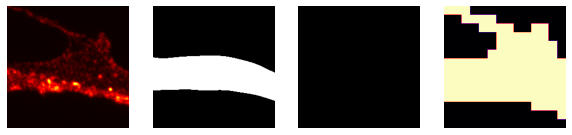

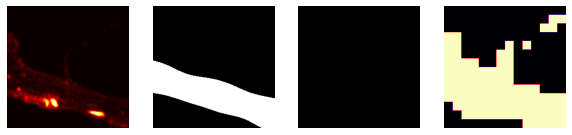

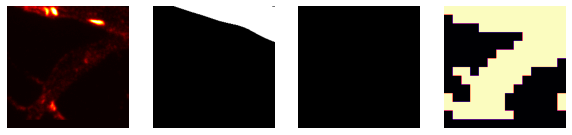

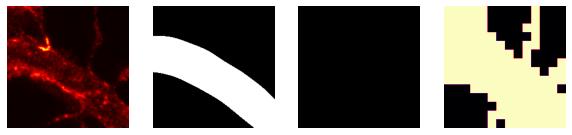

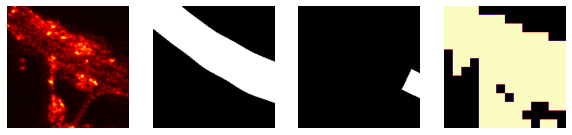

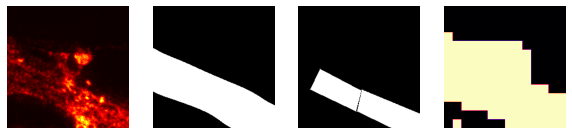

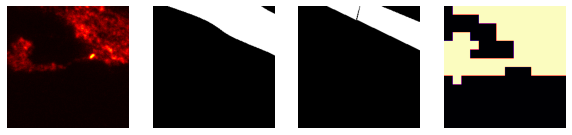

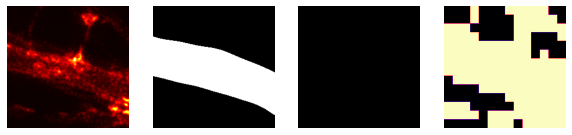

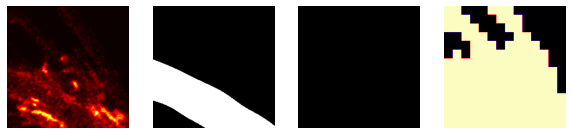

Average IoU: 0.562379378216761
Cluster 1 ring IoU: 0.00039695019585603964
Cluster 1 fibre IoU: 0.010986069246229881
Cluster 2 ring IoU: 0.17025522353386668
Cluster 2 fibre IoU: 0.562379378216761


In [8]:
def compute_iou(m1, m2):
    intersection = np.logical_and(m1, m2)
    union = np.logical_or(m1, m2)
    return np.sum(intersection) / np.sum(union)


def compute_cluster_ious(cluster_img, gt_img):
    ious = [] 
    for cid in np.unique(cluster_img):
        mask = np.zeros((224, 224))
        mask[cluster_img == cid] = 1
        ch0_iou = compute_iou(mask, gt_img[1])
        ch1_iou = compute_iou(mask, gt_img[2])
        ious.append([ch0_iou, ch1_iou])
    return np.array(ious)


kmeans = KMeans(n_clusters=INIT_CLASSES, random_state=42)
kmeans.fit(embeddings)
predictions = kmeans.labels_ 
preds_per_image = np.split(predictions, n_images)

print(np.unique(preds_per_image[0]))

all_ious = []
N = len(preds_per_image)

c1_ring_iou = []
c1_fibre_iou = []
c2_ring_iou = []
c2_fibre_iou = []
for i, (pred, gt, img) in enumerate(zip(preds_per_image, ground_truths, images)):
    pred = torch.tensor(pred, dtype=torch.float32)
    pred = pred.view(1, 1, 14, 14) 
    pred = F.interpolate(pred, (224, 224), mode="nearest").squeeze().cpu().int().numpy()
    iou = compute_iou(pred, gt[-1])
    cluster_ious = compute_cluster_ious(pred, gt)
    c1_ring_iou.append(cluster_ious[0, 0])
    c1_fibre_iou.append(cluster_ious[0, 1])
    c2_ring_iou.append(cluster_ious[1, 0])
    c2_fibre_iou.append(cluster_ious[1, 1])

    all_ious.append(iou)
    if i > N - 10:
        fig, axs = plt.subplots(1, 4, figsize=(10, 10))
        if "imagenet" in WEIGHTS.lower():
            axs[0].imshow(img[0], cmap="hot")
        else:
            axs[0].imshow(img, cmap="hot")
        axs[1].imshow(gt[-1], cmap='gray')
        axs[2].imshow(gt[-2], cmap='gray')
        axs[3].imshow(pred, cmap='magma')
        for ax in axs:
            ax.axis("off")
        plt.show()

print(f"Average IoU: {np.mean(all_ious)}")
print(f"Cluster 1 ring IoU: {np.mean(c1_ring_iou)}")
print(f"Cluster 1 fibre IoU: {np.mean(c1_fibre_iou)}")
print(f"Cluster 2 ring IoU: {np.mean(c2_ring_iou)}")
print(f"Cluster 2 fibre IoU: {np.mean(c2_fibre_iou)}")


### Recursive clustering

**Step 1**

In [9]:
print(predictions.shape)
foreground_predictions_ids = np.where(predictions == 1)[0]
opposite_ids = np.setdiff1d(np.arange(predictions.shape[0]), foreground_predictions_ids)
foreground_embeddings = embeddings[foreground_predictions_ids]
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(foreground_embeddings)
recursive_labels = [item + 1 for item in kmeans.labels_]
recursive_predictions = np.zeros(predictions.shape[0])
recursive_predictions[foreground_predictions_ids] = recursive_labels
recursive_predictions[opposite_ids] = 0
recursive_predictions_per_image = np.split(recursive_predictions, n_images)




(112112,)


/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


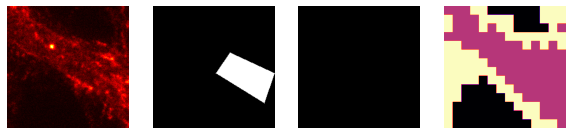

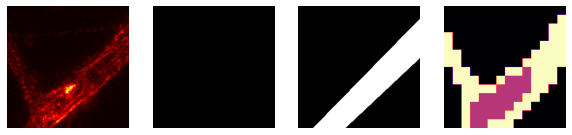

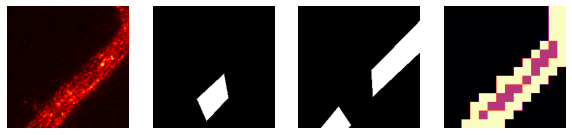

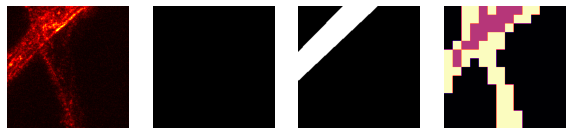

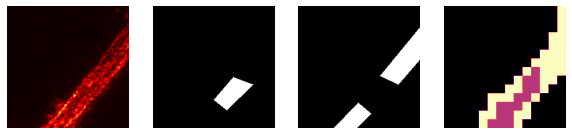

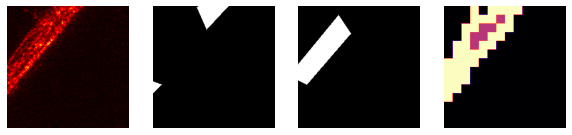

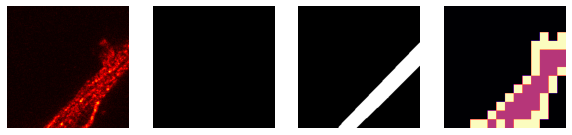

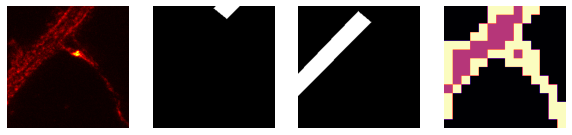

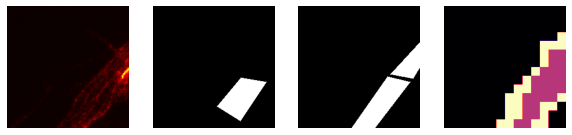

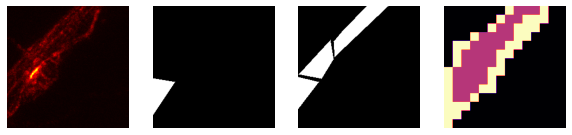

Cluster 1 ring IoU: 0.18528785055549488
Cluster 1 fibre IoU: 0.4431898896512531
Cluster 2 ring IoU: 0.06725691161712725
Cluster 2 fibre IoU: 0.26099679866837605


In [10]:
from collections import defaultdict
# Override
def compute_cluster_ious(cluster_img, gt_img):
    ious = defaultdict(lambda: {"ch1": None, "ch2": None})
    for cid in np.unique(cluster_img)[1:]: # We ignore the background from now on
        mask = np.zeros((224, 224))
        mask[cluster_img == cid] = 1
        ch0_iou = compute_iou(mask, gt_img[1])
        ch1_iou = compute_iou(mask, gt_img[2])
        ious[cid]["ch1"] = ch0_iou
        ious[cid]["ch2"] = ch1_iou
    return ious


N = len(preds_per_image)

counter = 0
all_ious = {
    1: {
        "ch1": [],
        "ch2": []
    },
    2: {
        "ch1": [],
        "ch2": []
    }
}
for i, (pred, gt, img) in enumerate(zip(recursive_predictions_per_image, ground_truths, images)):
    pred = torch.tensor(pred, dtype=torch.float32)
    pred = pred.view(1, 1, 14, 14) 
    pred = F.interpolate(pred, (224, 224), mode="nearest").squeeze().cpu().int().numpy()
    cluster_ious = compute_cluster_ious(pred, gt)
    for cluster_key in cluster_ious.keys():
        for channel_key in cluster_ious[cluster_key].keys():
            all_ious[cluster_key][channel_key].append(cluster_ious[cluster_key][channel_key])
    
    if counter < 10 and np.unique(pred).size > 2:
        fig, axs = plt.subplots(1, 4, figsize=(10, 10))
        if "imagenet" in WEIGHTS.lower():
            axs[0].imshow(img[0], cmap="hot")
        else:
            axs[0].imshow(img, cmap="hot")
        axs[1].imshow(gt[0], cmap='gray')
        axs[2].imshow(gt[1], cmap='gray')
        axs[3].imshow(pred, cmap='magma')
        for ax in axs:
            ax.axis("off")
        plt.show()
        counter += 1

print(f"Cluster 1 ring IoU: {np.mean(all_ious[1]['ch1'])}")
print(f"Cluster 1 fibre IoU: {np.mean(all_ious[1]['ch2'])}")
print(f"Cluster 2 ring IoU: {np.mean(all_ious[2]['ch1'])}")
print(f"Cluster 2 fibre IoU: {np.mean(all_ious[2]['ch2'])}")
    

**Step 2**

In [12]:
step2_predictions_ids = np.where(recursive_predictions == 2)[0]
step2_opposite_ids = np.setdiff1d(np.arange(recursive_predictions.shape[0]), step2_predictions_ids)
step2_embeddings = embeddings[step2_predictions_ids]
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(step2_embeddings)
step2_labels = [item + 1 for item in kmeans.labels_]
step2_predictions = np.zeros(recursive_predictions.shape[0])
step2_predictions[step2_predictions_ids] = step2_labels
step2_predictions[step2_opposite_ids] = 0
step2_predictions_per_image = np.split(step2_predictions, n_images)

/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[0. 1. 2.]


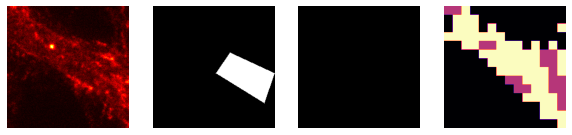

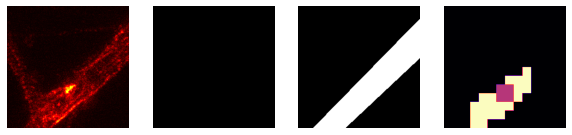

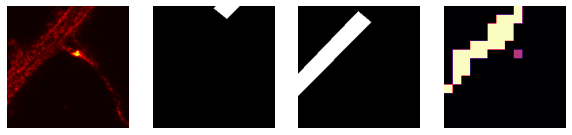

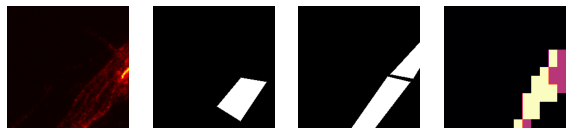

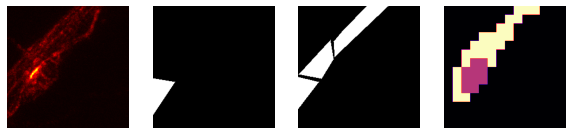

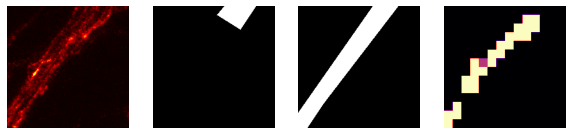

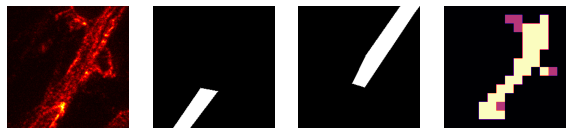

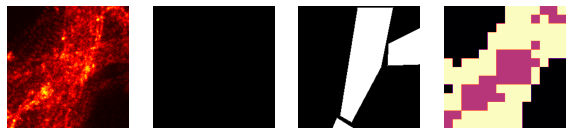

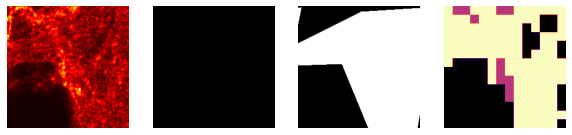

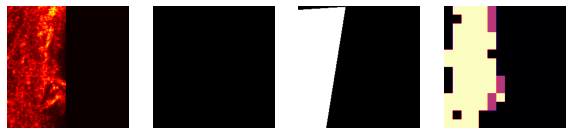

Cluster 1 ring IoU: 0.06207089449944752
Cluster 1 fibre IoU: 0.1756957611969878
Cluster 2 ring IoU: 0.17140165440864963
Cluster 2 fibre IoU: 0.328848513644013
Cluster 3 ring IoU: nan
Cluster 3 fibre IoU: nan


/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [13]:
N = len(step2_predictions_per_image)

print(np.unique(step2_predictions_per_image[10]))

counter = 0
all_ious = {
    1: {
        "ch1": [],
        "ch2": []
    },
    2: {
        "ch1": [],
        "ch2": []
    },
    3: {
        "ch1": [],
        "ch2": []
    },
}
for i, (pred, gt, img) in enumerate(zip(step2_predictions_per_image, ground_truths, images)):
    pred = torch.tensor(pred, dtype=torch.float32)
    pred = pred.view(1, 1, 14, 14) 
    pred = F.interpolate(pred, (224, 224), mode="nearest").squeeze().cpu().int().numpy()
    cluster_ious = compute_cluster_ious(pred, gt)
    for cluster_key in cluster_ious.keys():
        for channel_key in cluster_ious[cluster_key].keys():
            all_ious[cluster_key][channel_key].append(cluster_ious[cluster_key][channel_key])
    if counter < 10 and np.unique(pred).size > 2:
        fig, axs = plt.subplots(1, 4, figsize=(10, 10))
        if "imagenet" in WEIGHTS.lower():
            axs[0].imshow(img[0], cmap="hot")
        else:
            axs[0].imshow(img, cmap="hot")
        axs[1].imshow(gt[0], cmap='gray')
        axs[2].imshow(gt[1], cmap='gray')
        axs[3].imshow(pred, cmap='magma')
        for ax in axs:
            ax.axis("off")
        plt.show()
        counter += 1

print(f"Cluster 1 ring IoU: {np.mean(all_ious[1]['ch1'])}")
print(f"Cluster 1 fibre IoU: {np.mean(all_ious[1]['ch2'])}")
print(f"Cluster 2 ring IoU: {np.mean(all_ious[2]['ch1'])}")
print(f"Cluster 2 fibre IoU: {np.mean(all_ious[2]['ch2'])}")
print(f"Cluster 3 ring IoU: {np.mean(all_ious[3]['ch1'])}")
print(f"Cluster 3 fibre IoU: {np.mean(all_ious[3]['ch2'])}")
